# Quiz 2 - Model Comparisons
Wyatt Blair

5/5/2024

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

import sys
sys.path.append('../')

from data import get_data
from util import plot_data, evaluate_model

In [2]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

___
## **Data**: IPG2211A2N

I opted for a dataset on Kaggle which tracks electricity production from 1984 through 2017. This demonstrates several long term trends overlayed on top of the seasonal changes of electricity demand. The dataset was tagged as being "clean" and so it sounded like a good fit for my purposes.

Link to dataset: https://www.kaggle.com/datasets/shenba/time-series-datasets?resource=download

In [3]:
data = get_data()

In [4]:
data['data'].head(5)

,POINTS
DATE,
1/1/1985,72.5052
2/1/1985,70.6720
3/1/1985,62.4502
4/1/1985,57.4714
5/1/1985,55.3151


In [5]:
data['norm_data'].head(5)

,POINTS,DATE-INDEX
DATE,,
1/1/1985,0.232017,0
2/1/1985,0.207274,1
3/1/1985,0.096304,2
4/1/1985,0.029104,3
5/1/1985,0.000000,4


I googled IPG2211A2N and it led me down a rabbit hole. 

This dataset is tracking the Industrial Production: Utilities: Electric and Gas Utilities index which is stored in the database: FRED (Federal Reserve Economic Data). 

This database is maintained by the Research division of the Federal Reserve Bank of St. Louis that has more than 816,000 economic time series from various sources.

The index defines the unit as "Points" and provides no further explanation. For convenience's sake I'm going to rename the column to "Points".

**Sources**:
* [IPG2211A2N Index](https://www.tradingview.com/symbols/FRED-IPG2211A2N/)
* [FRED Wikipedia](https://en.wikipedia.org/wiki/Federal_Reserve_Economic_Data)

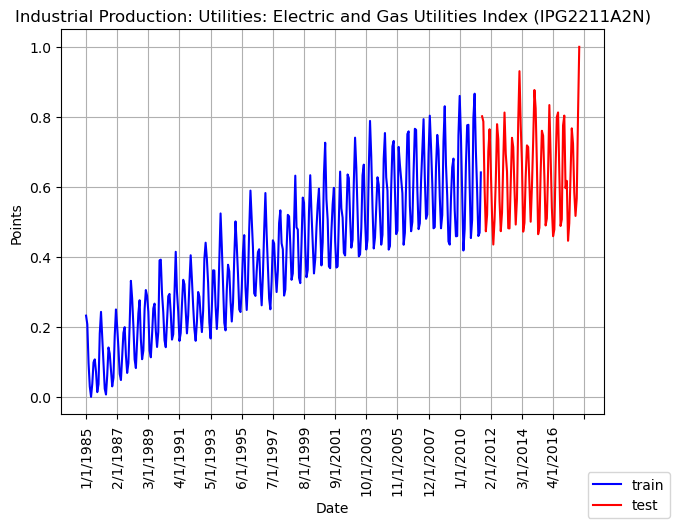

In [6]:
fig, ax = plt.subplots(1,1, figsize=(7, 5))
plot_data(ax)

fig.legend(loc='lower right')
plt.show()

___
## Autoencoder

$E_\phi: \mathscr{X} \xrightarrow{} \mathscr{Z}$

        
$z = E_\phi(x)$


$D_\theta: \mathscr{Z} \xrightarrow{} \mathscr{X}$


$x' = D_\theta(z)$


$E_\phi :=$ encoder, parameterized by $\phi$

$D_\theta :=$ decoder, parameterized by $\theta$ 

$x :=$ input message 

$z :=$ latent code 

$x' :=$ decoded message

In [7]:
class LSTMEncoder(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMEncoder, self).__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        outputs, (hidden, cell) = self.lstm(x)

        return outputs, hidden, cell

class LSTMDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMDecoder, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
        outputs, (hidden, cell) = self.lstm(x, (hidden, cell))
        predictions = self.fc(outputs)

        return predictions

class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMAutoencoder, self).__init__()
        
        self.encoder = LSTMEncoder(input_size, hidden_size, num_layers)
        self.decoder = LSTMDecoder(hidden_size, hidden_size, num_layers, output_size)

    def forward(self, x):
        encoder_output, hidden, cell = self.encoder(x)

        # # Decoder input should be created here depending on how you want to initialize it.
        # # A common method is to use the last input or a zero tensor as initial input.
        # decoded_input = torch.zeros_like(x)
        decoded_output = self.decoder(encoder_output, hidden, cell)
        
        return decoded_output

Training LSTMAutoencoder:   0%|          | 0/1 [00:00<?, ?it/s]

R2-Scores: 
--> TRAIN: -4.28617
--> TEST : -24.03348
--> FULL : -4.75786
MSE-Scores: 
--> TRAIN: 0.20433
--> TEST : 0.42249
--> FULL : 0.24775


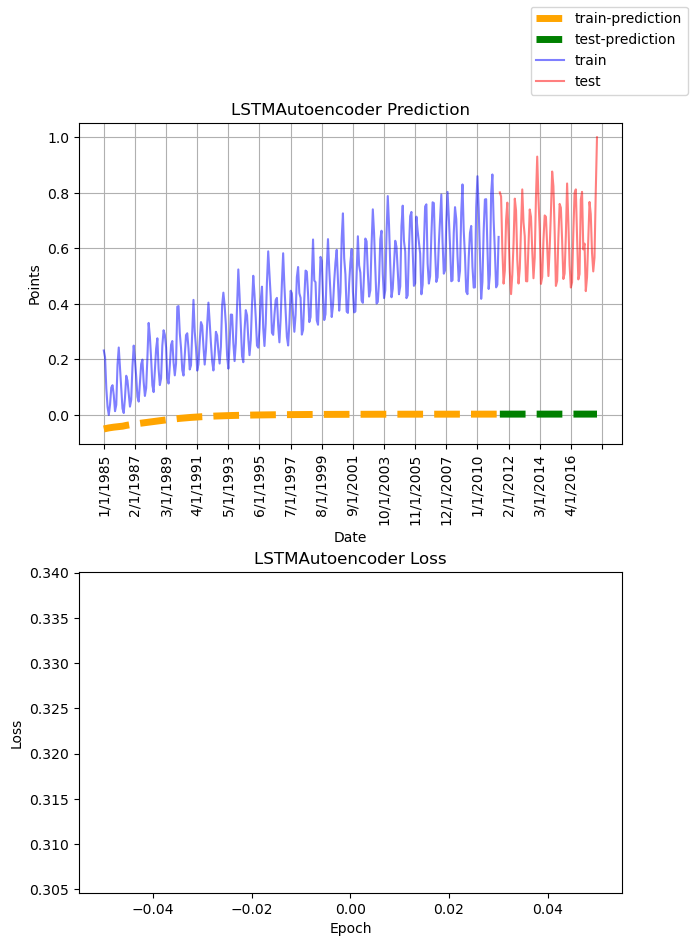

In [8]:
input_size = 1  # Number of features in the time series
hidden_size = 64
num_layers = 2
output_size = 1  # Predicting one feature


# instantiate model
model_kwargs = {
    'input_size': data['sequence_length'],
    'hidden_size': 64,
    'num_layers': 2,
    'output_size': 1
}
model = LSTMAutoencoder(**model_kwargs)

# run train/evaluation
evaluation_kwargs = {
    'model': model,
    'num_epochs': 100,
    'lr': 0.00001,
}
evaluate_model(**evaluation_kwargs)